import 相關 package

In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

讀取貸款資料

In [2]:
import pandas as pd

data = pd.read_csv("accepted_2018_to_2018Q4.gz", low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


讀取欄位描述

In [3]:
browse_notes = pd.read_excel("LCDataDictionary.xlsx", sheet_name=1)
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


將欄位描述名稱與資料欄位名稱整合

In [4]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values

In [5]:
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [6]:
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat)

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U35')

In [7]:
np.setdiff1d(data_feat, browse_feat)

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'orig_projected_additional_accrued_interest',
       'out_prncp', 'out_prncp_inv', 'payment_plan_start_date',
       'policy_code', 'pymnt_plan', 'recoveries', 'settlement_amount',
       'settlement_date', 'settlement_percentage', 'settlement_status',
       'settlement_term', 'total_pymnt', 'total_pymnt_inv',
       'total

In [8]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)

In [9]:
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Columns: 109 entries, acc_now_delinq to zip_code
dtypes: float64(90), int64(1), object(18)
memory usage: 411.8+ MB


In [10]:
X.select_dtypes('object').head()

,addr_state,application_type,disbursement_method,earliest_cr_line,emp_length,emp_title,grade,home_ownership,initial_list_status,purpose,sec_app_earliest_cr_line,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,Cash,Jan-2009,8 years,General Manager,D,RENT,w,other,NaN,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,Cash,Jul-1998,2 years,IT Director,B,OWN,w,debt_consolidation,NaN,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,Cash,Jul-2007,< 1 year,Client services,G,RENT,w,medical,Feb-2005,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,Cash,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,w,debt_consolidation,NaN,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,Cash,Jan-1998,9 years,Scale Technician,A,RENT,w,major_purchase,NaN,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


更改字串格式到日期格式

In [11]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
X['sec_app_earliest_cr_line'] = pd.to_datetime(X['sec_app_earliest_cr_line'], infer_datetime_format=True)

更改文字格式到數字格式

In [12]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

處理缺失資料（missing value）

列出遺失資料的比例

In [13]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

pct_tl_nvr_dlq                         0.000004
avg_cur_bal                            0.000081
all_util                               0.000260
revol_util                             0.001195
dti                                    0.002286
mths_since_recent_bc                   0.012515
bc_open_to_buy                         0.013303
percent_bc_gt_75                       0.013319
bc_util                                0.013737
num_tl_120dpd_2m                       0.025046
mo_sin_old_il_acct                     0.037174
mths_since_rcnt_il                     0.037174
emp_length                             0.084781
emp_title                              0.110368
mths_since_recent_inq                  0.123788
il_util                                0.163201
mths_since_last_delinq                 0.558620
mths_since_recent_revol_delinq         0.711878
mths_since_last_major_derog            0.768128
mths_since_recent_bc_dlq               0.801895
sec_app_chargeoff_within_12_mths       0

In [14]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

將遺失資料填入最大或最小值

In [15]:
fill_empty = ['emp_title', 'verification_status_joint']
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq','sec_app_mths_since_last_major_derog']
fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())

移除高度相關性的特徵

In [16]:
num_feat = X.select_dtypes('number').columns.values
X[num_feat].nunique().sort_values()

num_tl_120dpd_2m                   1
acc_now_delinq                     2
num_tl_30dpd                       2
inq_last_6mths                     6
sec_app_inq_last_6mths             7
                               ...  
total_il_high_credit_limit    128691
total_bal_ex_mort             139900
tot_cur_bal                   254794
tot_hi_cred_lim               266282
id                            495242
Length: 90, dtype: int64

In [17]:
X = X.drop(['num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

In [18]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(X[comb[0]], X[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [19]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['sec_app_fico_range_high', 'sec_app_fico_range_low'],
       ['sec_app_num_rev_accts', 'sec_app_open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U35')

In [20]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

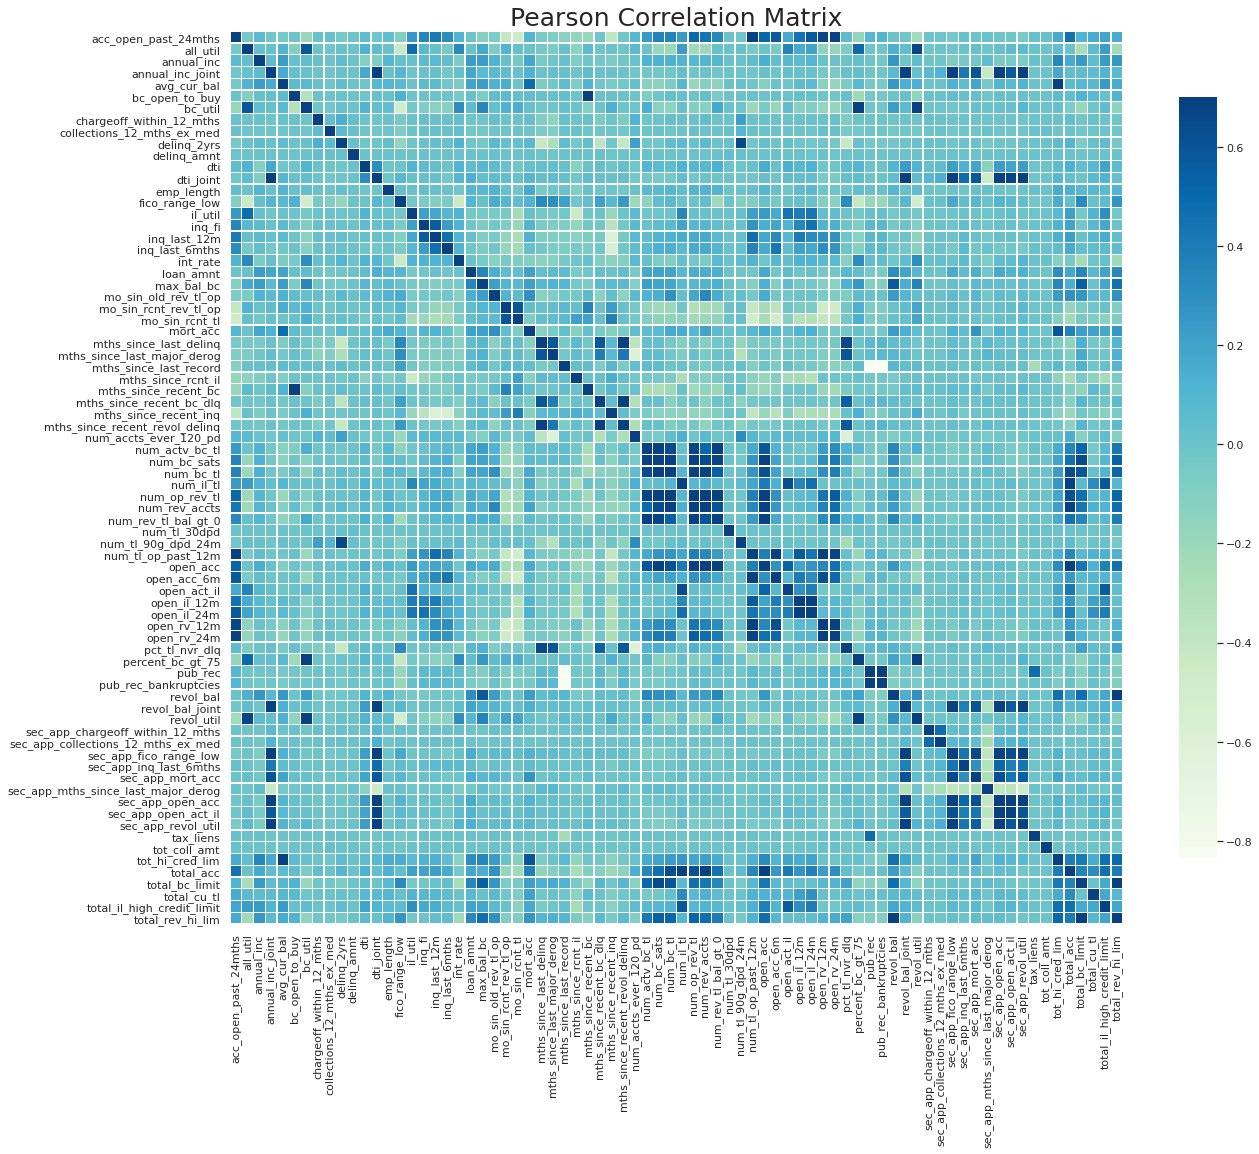

In [21]:
sns.set(style="whitegrid", font_scale=1)

plt.figure(figsize=(20,20))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(X.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=False, annot_kws={"size":10}, cbar_kws={"shrink": .7})

In [22]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
disbursement_method               2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
grade                             7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

In [23]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

In [24]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [25]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [26]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

我們的預測目標是貸款的好壞，能不能順利收回貸款的狀況

我們根據貸款情況定義了以下狀況
1. Current: 目前未償還貸款都是最新的
2. In Grace Period: 過期但還在寬限期內
3. Late(16-30): 逾期16到30天
4. Late(31-120): 逾期31到120天
5. Fully paid: 3年到5年內，貸款全額付清
6. Default: 長期未貸款
7. Charged Off: 不再有合理期望進一步付款的貸款

In [27]:
data['loan_status'].value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [28]:
y = data['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype('int')
y.value_counts()

1    477544
0     17698
Name: loan_status, dtype: int64

區分訓練與測試資料

In [29]:
X_mod = X[X.grade == 'E'].copy()
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

In [30]:
cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=0.03,
                           iterations=1000,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy (test): 0.632
Precision (test): 0.929
Recall (test): 0.644


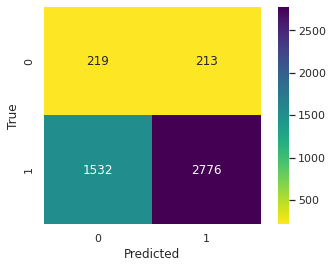

In [31]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

Accuracy (constant prediction): 0.909
Precision (constant prediction): 0.909
Recall (constant prediction): 1.000


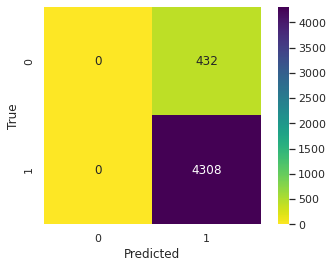

In [32]:
y_pred_const = np.ones(y_test.size)

acc = accuracy_score(y_test, y_pred_const)
prec = precision_score(y_test, y_pred_const)
rec = recall_score(y_test, y_pred_const)
print(f'''Accuracy (constant prediction): {acc:.3f}
Precision (constant prediction): {prec:.3f}
Recall (constant prediction): {rec:.3f}''')

cm = confusion_matrix(y_test, y_pred_const)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

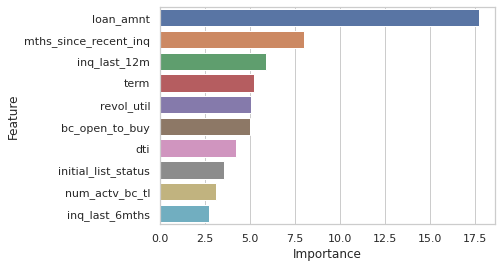

In [33]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

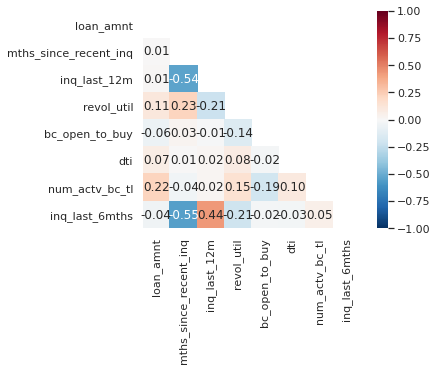

In [34]:
corr = X_mod[df['Feature'].values].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2f');

/home/lzrong/anaconda3/envs/fintech/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


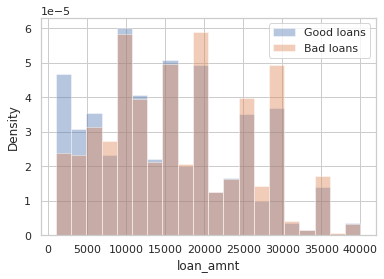

In [35]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

/home/lzrong/anaconda3/envs/fintech/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


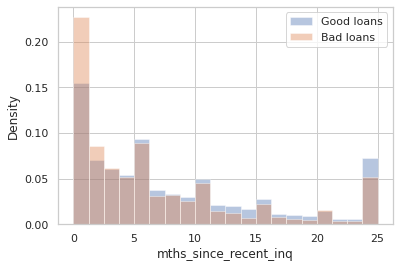

In [36]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

/home/lzrong/anaconda3/envs/fintech/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


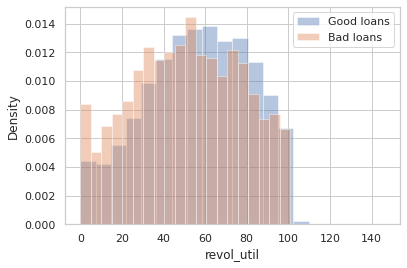

In [37]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();